## DSCI 552 PS 4
### Bias and Fair Models - Predicting Happiness 

Each row of the dataset is a REGION

• **Id2 which gives the Region Id,**

• **totalGroup1 is the number of people in ethnic group 1,**

• **totalGroup2 is the number of people in ethnic group 2,**

• **percent_bachelorPlus is the percentage of population with at least a bachelor’s degree**

• **households_meanIncome gives us the mean income per household in the region and**

• **meanvalence gives us the mean happiness in the region**


Correlation between the predicted outcome and independent predictors can be used as a proxy for
measuring fairness. Our goal is to ensure that valence predictions are not biased towards one of
the ethnic group variables. We define protected variables as ones along which biases can be
observed in the outcome. In our case, these are – totalGroup1 and (or) totalGroup2. Your analysis
report should consist of the following four models.”

1. Ground Truth Model – Generate correlations and scatterplots of ground truth valence
with respect to percent_bachelorPlus and households_meanIncome with each of the
scatterplots conditioned on totalGroup1 and totalGroup2. From the scatterplots state
whether you see a bias to one ethnic group? Describe why you think so.
The prediction models are considered fair if the correlations and scatter plot of predicted outcome
vs independent variables conditioned on ethnic group variables are similar to that of ground truth
model.

2. Ethnic Group Aware Model (Prediction Model I) – Build a linear regression model using
all predictors, on a percentage of the data provided. Predict the valence on the entire dataset.
Analyze fairness of predicted valence by comparing the correlations and scatterplots of
Group Aware Model with Ground Truth Model. Report your observations on the
comparison and state if there is bias to one of the two groups when the predicted valence
threshold is set to 5.8.

3. Ethnic Group Blind Model (Prediction Model II) – Build a linear regression model
without using totalGroup1 and totalGroup2 as predictors, on a percentage of the data
provided. Predict the valence on the entire dataset. Analyze fairness of predicted valence
by comparing the correlations and scatterplots of Group Blind Model with Ground Truth
Model. Report your observations on the comparison. Does hiding these protected variables
change the bias identified in the previous model change here? Describe either way.

4. Fair Model – Our R&D team has published a paper on debiasing linear models (available
at: https://arxiv.org/pdf/1910.12854.pdf). On the basis of this work, we have written two
helper functions that you have to use in order to debias the outcome variable. The python
file consisting of these helper functions are available in fair_var.py.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## data preparation and analysis
import pandas as pd 
from pandas.plotting import scatter_matrix
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy as sp 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

## modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fair_var import *

In [2]:
## import custom function to get feature names
from helper import get_feature_names

In [3]:
df = pd.read_csv(r'../data/chirper-happiness.csv')
print(df.shape)

(2110, 6)


In [4]:
df.head(3)

,Id2,totalGroup1,totalGroup2,percent_bachelorPlus,meanvalence,households_meanIncome
0,6037101110,1244,2319,19.4,5.863903,68938
1,6037101122,304,2175,27.2,5.963174,120490
2,6037101210,2434,2078,16.6,5.623312,54481


In [5]:
df.describe()

,Id2,totalGroup1,totalGroup2,percent_bachelorPlus,meanvalence,households_meanIncome
count,2.110000e+03,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000
mean,6.037379e+09,1607.534597,988.572038,28.824028,5.828721,78324.632227
std,2.057889e+05,1097.976544,995.119185,20.642709,0.113931,43137.269798
min,6.037101e+09,16.000000,1.000000,0.000000,5.110000,9040.000000
25%,6.037206e+09,695.750000,169.000000,11.400000,5.761016,50404.000000
50%,6.037402e+09,1450.000000,636.500000,23.500000,5.822492,67437.500000
75%,6.037541e+09,2368.750000,1587.500000,42.875000,5.889826,92943.000000
max,6.037930e+09,5976.000000,5929.000000,84.200000,6.941389,387177.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2110 entries, 0 to 2109
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id2                    2110 non-null   int64  
 1   totalGroup1            2110 non-null   int64  
 2   totalGroup2            2110 non-null   int64  
 3   percent_bachelorPlus   2110 non-null   float64
 4   meanvalence            2110 non-null   float64
 5   households_meanIncome  2110 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 99.0 KB


# EDA, Data Cleaning, and Transforming steps
We should clean data by: fill missing vals (median imputation), scale the datasets, remove outliers, and do one-hot encoding for categorical vars.

In [7]:
df.isnull().sum()

Id2                      0
totalGroup1              0
totalGroup2              0
percent_bachelorPlus     0
meanvalence              0
households_meanIncome    0
dtype: int64

In [8]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

In [19]:
## Normalize data
min_max_scaler = MinMaxScaler()
nums_scaled = pd.DataFrame(min_max_scaler.fit_transform(df[num_cols]))
nums_scaled.columns = num_cols

## Outlier removal: get indicies of outlier locations
outlier_locs = []
for col in num_cols:
    curr = df[col]
    mean, std = np.mean(curr), np.std(curr)
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off
    # print(col, lower, upper)  
    for idx, val in curr.items():
        if val < lower or val > upper:
            outlier_locs.append(idx)
outliers = list(set(outlier_locs))
## df2 is just df without the outliers
df2 = df.drop(df.index[outliers])
nums_scaled2 = nums_scaled.drop(nums_scaled.index[outliers])
print(df.shape, df2.shape)

(2110, 6) (2021, 6)


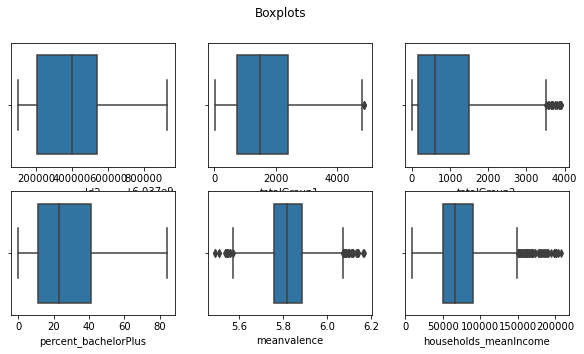

In [27]:
# ## boxplots for numerical vars
fig, axes = plt.subplots(2, 3, sharex = False, figsize=(10,5))
fig.suptitle('Boxplots')

for i, var in enumerate(num_cols):
    if i < 3:
        row = 0
    elif i >= 3: 
        row = 1
    col = i % 3
#     sns.boxplot(ax=axes[row,col], data=df, x=var) # skewed
    sns.boxplot(ax=axes[row,col], data=df2, x=var)
# plt.savefig('images/boxplots_1.png')

Text(0.5, 1.0, 'Distribution of households_meanIncome')

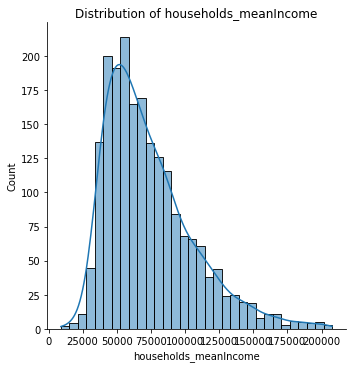

<Figure size 720x432 with 0 Axes>

In [22]:
var = 'households_meanIncome'
# g = sns.displot(data=df, x=var, kde=True)  # skewed
g = sns.displot(data=df2, x=var, kde=True)
plt.figure(figsize=(10,6))
# g.fig.subplots_adjust(top=.95)
g.ax.set_title("Distribution of " + var)
# # plt.savefig('../images/PS_1/price_histogram.png')

In [65]:
# # ## View correlations btwn features
# plt.figure(figsize=(10,6))
# sns.heatmap(df2.corr(), annot=True, cmap="hot_r")
# # # plt.savefig('images/heatmap_1.png')

1. Ground Truth Model – Generate correlations and scatterplots of ground truth valence
with respect to percent_bachelorPlus and households_meanIncome with each of the
scatterplots conditioned on totalGroup1 and totalGroup2. From the scatterplots state
whether you see a bias to one ethnic group? Describe why you think so

In [32]:
sns.set(rc={'figure.figsize':(10, 8)})

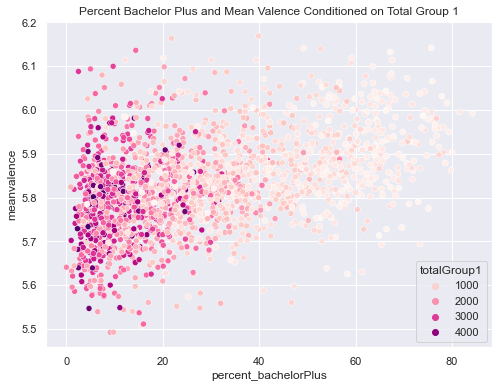

In [68]:
# scatterplot of valence and perc bp
plt.title('Percent Bachelor Plus and Mean Valence Conditioned on Total Group 1')
sns.scatterplot(data=df2, x="percent_bachelorPlus", y="meanvalence", hue="totalGroup1", palette='RdPu')
plt.savefig('../images/scatter_1_ps4.png')

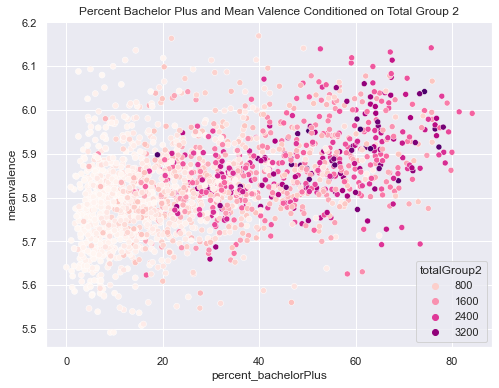

In [69]:
plt.title('Percent Bachelor Plus and Mean Valence Conditioned on Total Group 2')
sns.scatterplot(data=df2, x="percent_bachelorPlus", y="meanvalence", hue="totalGroup2", palette='RdPu')
plt.savefig('../images/scatter_2_ps4.png')

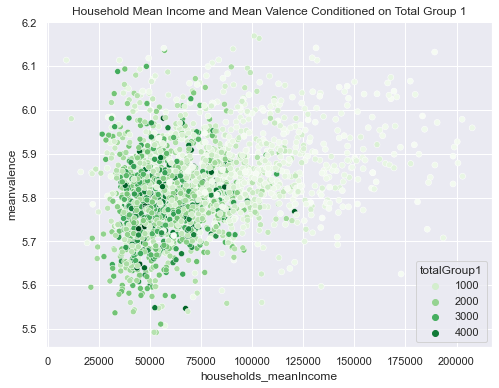

In [70]:
# scatterplot of valence and households mean income
plt.title('Household Mean Income and Mean Valence Conditioned on Total Group 1')
sns.scatterplot(data=df2, x='households_meanIncome', y="meanvalence", hue="totalGroup1", palette='Greens')
plt.savefig('../images/scatter_3_ps4.png')

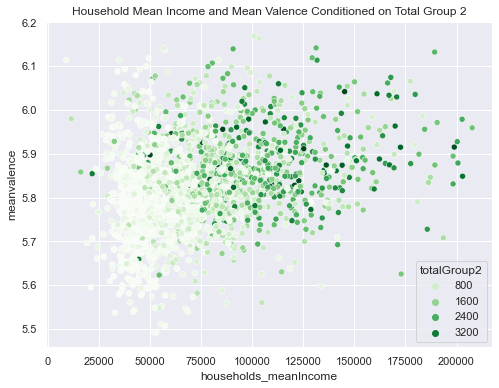

In [71]:
plt.title('Household Mean Income and Mean Valence Conditioned on Total Group 2')
sns.scatterplot(data=df2, x='households_meanIncome', y="meanvalence", hue="totalGroup2", palette='Greens')
plt.savefig('../images/scatter_4_ps4.png')

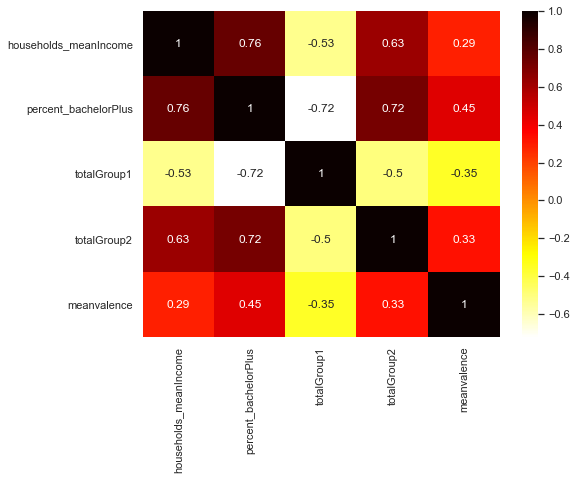

In [67]:
## corrplot
sns.set(rc={'figure.figsize':(8,6)})
cols = ["households_meanIncome","percent_bachelorPlus", "totalGroup1", "totalGroup2", "meanvalence"]
sns.heatmap(df2[cols].corr(), annot=True, cmap="hot_r")
plt.savefig('../images/heatmap_1_ps4.png')

# Lin Regression Modeling 
#### 2. Ethnic Group Aware Model (Prediction Model I)
Build a linear regression model using all predictors, on a percentage of the data provided. Predict the valence on the entire dataset.
Analyze fairness of predicted valence by comparing the correlations and scatterplots of
Group Aware Model with Ground Truth Model. Report your observations on the
comparison and state if there is bias to one of the two groups when the predicted valence
threshold is set to 5.8.

<!-- 3. Ethnic Group Blind Model (Prediction Model II) – Build a linear regression model
without using totalGroup1 and totalGroup2 as predictors, on a percentage of the data
provided. Predict the valence on the entire dataset. Analyze fairness of predicted valence
by comparing the correlations and scatterplots of Group Blind Model with Ground Truth Model. Report your observations on the comparison. Does hiding these protected variables
change the bias identified in the previous model change here? Describe either way.

4. Fair Model – Our R&D team has published a paper on debiasing linear models (available
at: https://arxiv.org/pdf/1910.12854.pdf). On the basis of this work, we have written two
helper functions that you have to use in order to debias the outcome variable. The python
file consisting of these helper functions are available in fair_var.py. -->

In [47]:
## Transformation Pipeline
df3 = df2.drop(['meanvalence'],axis=1)
df3.head()

,Id2,totalGroup1,totalGroup2,percent_bachelorPlus,households_meanIncome
0,6037101110,1244,2319,19.4,68938
1,6037101122,304,2175,27.2,120490
2,6037101210,2434,2078,16.6,54481
3,6037101220,509,1370,19.8,51880
4,6037101300,365,3116,31.0,90933


In [48]:
## Split in train/test/valid
X = df3.to_numpy()
y = df2['meanvalence'].to_numpy()  ## target var is UNSCALED
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print(X_train.shape, X_test.shape)

(2021, 5) (2021,)
(1616, 5) (405, 5)


In [49]:
vifs = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(len(vifs))
## NOTE: any VIF > 4 needs investigation for possible multicollinearity!
print(sorted(vifs)[::-1])

5
[19.755982245030353, 4.489073058692379, 2.4731861559246955, 2.161324432375338, 2.111025987109582]


In [50]:
n = X.shape[0]  ## sample size
p = X.shape[1]  ## num of predictors

In [53]:
## OLS Linear Reg Model - using sm
X_train_df = pd.DataFrame(X_train, columns=df3.columns)

# X_train_df.head()
X0_train = sm.add_constant(X_train_df)
model = sm.OLS(y_train, X0_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     82.04
Date:                Fri, 19 Mar 2021   Prob (F-statistic):           7.07e-77
Time:                        15:27:30   Log-Likelihood:                 1540.0
No. Observations:                1616   AIC:                            -3068.
Df Residuals:                    1610   BIC:                            -3036.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   145.1828     71.787      2.022      0.043       4.377     285.988
Id2                   -2.309e-08   1.19e-08     -1.942      0.052   -4.64e-08    2.33e-10
totalGroup1           -4.167e-06   3.16e-06     -1.317      0.188   -1.04e-05    2.04e-06
totalGroup2            1.999e-06   3.68e-06      0.543      0.587   -5.22e-06    9.22e-06
percent_bachelorPlus      0.0025      0.000      9.556      0.000       0.002       0.003
households_meanIncome -2.583e-07   1.19e-07     -2.172      0.030   -4.92e-07   -2.51e-08
==============================================================================
Omnibus:                       38.043   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.040
Skew:                           0.226   Prob(JB):                     2.49e-13
Kurtosis:                       3.811   Cond. No.                     1.86e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
params = model.params
params.sort_values(ascending=False)

const                    1.451828e+02
percent_bachelorPlus     2.469868e-03
totalGroup2              1.998570e-06
Id2                     -2.308989e-08
households_meanIncome   -2.583147e-07
totalGroup1             -4.166977e-06
dtype: float64

In [58]:
# ## Predict on test values
# X_test_df = pd.DataFrame(X_test, columns=df3.columns)
# X0_test = sm.add_constant(X_test_df)
# y_pred = model.predict(X0_test)

In [59]:
## Predict on ALL values (including training set)

X_df = pd.DataFrame(X, columns=df3.columns)
X0_df = sm.add_constant(X_df)
y_pred = model.predict(X0_df)

In [61]:
## get RMSE
# rmse = sm.tools.eval_measures.rmse(y_test, y_pred)
rmse = sm.tools.eval_measures.rmse(y, y_pred)
round(rmse,4)

0.0924

In [26]:
# 10 fold cv for OLS using sklearn
def list_models(models = dict()):
    models['linear_reg'] = LinearRegression()
    alphas = [round(x, 2) for x in np.linspace(0,1,11)]
    for a in alphas:
        models['lasso_reg_'+str(a)] = Lasso(alpha=a)
        models['ridge_reg_'+str(a)] = Ridge(alpha=a)
        models['en_reg_'+str(a)] = ElasticNet(alpha=a)
    return models
 
def eval_one_model(X, y, model, folds, metric):
	scores = cross_val_score(estimator=model, X=X, y=y, scoring=metric, cv=folds, n_jobs=1)
	return scores

def eval_multi_models(X, y, models, folds=10, metric='neg_root_mean_squared_error'):   
    results = {}
    print(f"Evaluate using {metric}:\n")
    for name, model in models.items():
        scores = eval_one_model(X, y, model, folds, metric)
        if scores is not None:
            results[name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)
            print(f'{name}: Mean {metric}:{mean_score:.3f}')
    return results

results = eval_multi_models(X, y, {'linear_reg': LinearRegression()})

Evaluate using neg_root_mean_squared_error:

linear_reg: Mean neg_root_mean_squared_error:-6975.212


In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)
r2 = round(r2_score(y_test, y_pred) ,4)
print(f'Coefficient of determination R^2: {r2}')
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R^2 is {round(adj_r2,4)}')

Coefficient of determination R^2: 0.5695
Adjusted R^2 is 0.5686


# Regularized Regression for Modeling and Comparing Models

In [29]:
# ## Split in train/test/valid
# X = arr_cleaned
# y = df2['price'].to_numpy()
# print(X.shape, y.shape)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
# print(X_train.shape, X_test.shape)

(9603, 29) (9603,)
(7682, 29) (1921, 29)


## Spot check / Compare models
#### Try diff models compare results using kfold cv

In [34]:
models = list_models() 
results = eval_multi_models(X, y, models)

Evaluate using neg_root_mean_squared_error:

linear_reg: Mean neg_root_mean_squared_error:-7016.673
lasso_reg_0.0: Mean neg_root_mean_squared_error:-6975.212
ridge_reg_0.0: Mean neg_root_mean_squared_error:-7052.890
en_reg_0.0: Mean neg_root_mean_squared_error:-6975.212
lasso_reg_0.1: Mean neg_root_mean_squared_error:-6975.211
ridge_reg_0.1: Mean neg_root_mean_squared_error:-6975.211
en_reg_0.1: Mean neg_root_mean_squared_error:-8037.064
lasso_reg_0.2: Mean neg_root_mean_squared_error:-6975.206
ridge_reg_0.2: Mean neg_root_mean_squared_error:-6975.212
en_reg_0.2: Mean neg_root_mean_squared_error:-8662.074
lasso_reg_0.3: Mean neg_root_mean_squared_error:-6975.196
ridge_reg_0.3: Mean neg_root_mean_squared_error:-6975.217
en_reg_0.3: Mean neg_root_mean_squared_error:-9051.750
lasso_reg_0.4: Mean neg_root_mean_squared_error:-6975.183
ridge_reg_0.4: Mean neg_root_mean_squared_error:-6975.224
en_reg_0.4: Mean neg_root_mean_squared_error:-9320.273
lasso_reg_0.5: Mean neg_root_mean_squared_err

In [35]:
mean_results = {name: np.abs(np.round(np.mean(arr), 4)) for name, arr in results.items()}
## sort results with 'best' models first (having lowest error scores)
sorted(mean_results.items(), key=lambda x: x[1])

[('lasso_reg_1.0', 6975.0589),
 ('lasso_reg_0.9', 6975.0784),
 ('lasso_reg_0.8', 6975.0982),
 ('lasso_reg_0.7', 6975.1191),
 ('lasso_reg_0.6', 6975.1382),
 ('lasso_reg_0.5', 6975.1562),
 ('lasso_reg_0.4', 6975.1833),
 ('lasso_reg_0.3', 6975.1964),
 ('lasso_reg_0.2', 6975.2056),
 ('lasso_reg_0.1', 6975.2106),
 ('ridge_reg_0.1', 6975.211),
 ('ridge_reg_0.2', 6975.2124),
 ('lasso_reg_0.0', 6975.2125),
 ('en_reg_0.0', 6975.2125),
 ('ridge_reg_0.3', 6975.2168),
 ('ridge_reg_0.4', 6975.224),
 ('ridge_reg_0.5', 6975.234),
 ('ridge_reg_0.6', 6975.2468),
 ('ridge_reg_0.7', 6975.2624),
 ('ridge_reg_0.8', 6975.2807),
 ('ridge_reg_0.9', 6975.3017),
 ('ridge_reg_1.0', 6975.3253),
 ('linear_reg', 7016.6731),
 ('ridge_reg_0.0', 7052.8904),
 ('en_reg_0.1', 8037.064),
 ('en_reg_0.2', 8662.0743),
 ('en_reg_0.3', 9051.7502),
 ('en_reg_0.4', 9320.2725),
 ('en_reg_0.5', 9518.0295),
 ('en_reg_0.6', 9670.6159),
 ('en_reg_0.7', 9792.481),
 ('en_reg_0.8', 9892.3975),
 ('en_reg_0.9', 9976.0398),
 ('en_reg_1.0',

Looks like Lasso does the best at alpha=1.0

In [36]:
mean_rmse_df = pd.DataFrame.from_dict(mean_results, orient='index')
mean_rmse_df.columns = ['RMSE']
mean_rmse_df = mean_rmse_df.sort_values(by='RMSE')
# mean_rmse_df.head(10)

<AxesSubplot:title={'center':'Model Results of 10-fold CV'}, xlabel='RMSE'>

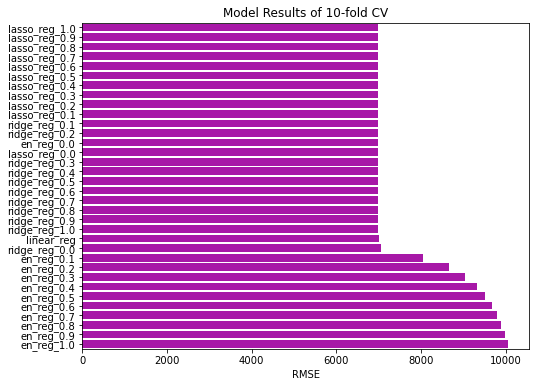

In [37]:
plt.figure(figsize=(8,6))
plt.title('Model Results of 10-fold CV')
sns.barplot(x='RMSE', y=mean_rmse_df.index, data=mean_rmse_df, color = 'm')
# plt.savefig('../images/PS_1/rmse_results_barchart.png')

# Plot Final Model

In [38]:
# Lasso model
alpha = 1.0
lasso_reg = Lasso(alpha=alpha)
print(lasso_reg)
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)
print('Coefficients: \n', lasso_reg.coef_)
print(f'Root Mean squared error: {round(mean_squared_error(y_test, y_pred_lasso, squared=False), 4)}')
r2 = round(r2_score(y_test, y_pred_lasso) ,4)
print(f'Coefficient of determination R^2: {r2}')
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R^2 is {round(adj_r2,4)}')

Lasso()
Coefficients: 
 [ 3.36106479e+04 -2.32755136e+04  2.50170472e+03 -5.91178717e+01
  6.06742944e+03 -3.04748344e+03  0.00000000e+00  1.52005574e-01
 -1.39686171e+03 -2.93972146e+02  1.28119062e+03 -4.74619732e+03
 -5.43149969e+02  8.11238854e+02  0.00000000e+00 -3.13266713e+03
  1.13896837e-11 -2.61411761e+03  3.45572691e+03 -5.44544643e+03
  2.65910917e+03  6.68781225e+02  0.00000000e+00  5.19210756e+02
 -1.94302819e+02 -8.13166062e+02  0.00000000e+00  6.26865119e+01
 -2.77371226e+02]
Root Mean squared error: 7242.7204
Coefficient of determination R^2: 0.5695
Adjusted R^2 is 0.5686


In [39]:
lasso_results = list(zip(feature_names, lasso_reg.coef_))
lasso_res_df = pd.DataFrame(lasso_results, columns=['feature_name','coefficient'])
lasso_res_df['coefficient'] =lasso_res_df['coefficient'].round(2)
lasso_res_df = lasso_res_df.sort_values(by='coefficient', ignore_index=True)
print(lasso_res_df.shape)

(29, 2)


In [40]:
lasso_to_plot = pd.concat([lasso_res_df.head(10), lasso_res_df.tail(10)])

Text(0, 0.5, 'Magnitude')

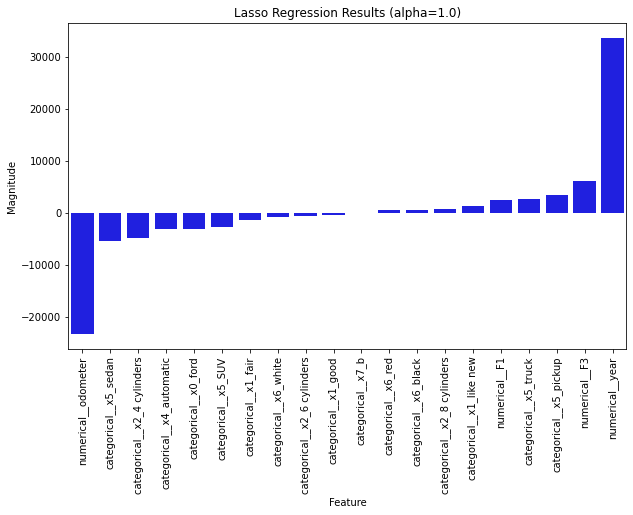

In [41]:
plt.figure(figsize=(10,6))
plt.title(f'Lasso Regression Results (alpha={alpha})')
sns.barplot(x='feature_name', y='coefficient', data=lasso_to_plot, color = 'b')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Magnitude')
# plt.savefig('../images/PS_1/lasso_coefficients.png')